<a href="https://colab.research.google.com/github/raaraya1/Personal-Proyects/blob/main/Cursos/Gurobi/Marketing_Campaign_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problema de Campañas de Marketing (Solver Gurobi)**

**Contexto:** El equipo de marketing necesita identificar que productos ofrecer a cada cliente en funcion de maximizar las utilidades de la empresa. Ademas, el problema se encuentra sujeto a restricciones del tipo:
- Limites de presupuesto para invertir en campañas de publicidad.
- Numero minimo de productos que se deben publicitar.
- Tasas de retorno sobre la inversion que las campañas de publicidad deben cumplir.

**Fuente:** https://www.gurobi.com/resource/marketing-campaign-optimization-jupyter-notebook/

# **Modelo (Planificacion Agregada)**

**Conjuntos:**

$k \in K$ : Segmentos de clientes.

$j \in J$ : Conjunto de productos.

**Parametros:**

$\pi_{kj}$ : Rentabilidad esperada de ofrecer el producto j al segmento k.

$v_{kj}$ : Costo variable de ofrecer el producto j al segmento k.

$N_{k}$: Cantidad de clientes pertenecientes al segmento k.

$Q_{j}$: Minimo de productos j que debo ofrecer.

$R$: Tasa de rentabilidad minima que exige la empresa.

$B$: Preupuesto disponible para invertir en campañas de publicidad.

$M$: Gran M.

**Variables:**

$Y_{j k}$: Cantidad de clientes del segmento k a los cuales les ofrezco el producto j.

$z$: Incremento en el prosupuesto B, en orden de hacer factible las campañas publicitarias.

**Funcion Objetivo:**

\begin{equation}
Max \sum_{j} \sum_{k} \pi_{jk} Y_{jk} - M*z
\end{equation}

**Restricciones:**

1) No puedo ofrecer mas productos que los clientes existentes en un segmento.

\begin{equation}
\sum_{j}Y_{kj} \leq N_{k} \quad \forall k \in K
\end{equation}

2) El costo de la campaña tiene que estar sujeto al presupuesto disponible (incluido la deuda que puedo sumar en orden de hacer factible el problema)

\begin{equation}
\sum_{k} \sum_{j} v_{jk}Y_{jk} \leq B + z
\end{equation}

3) Se debe de cumplir un minimo de ofertas por producto.

\begin{equation}
\sum_{k} Y_{jk} \geq Q_{j}
\quad \forall j \in J
\end{equation}

4) El retorno esperado de hacer la campaña debe superar en un R% el costo de hacerla (inversion)

\begin{equation}
\sum_{k} \sum_{j} \pi_{jk}Y_{jk} \geq (1 + R) \sum_{k} \sum_{j} v_{jk}Y_{jk}
\end{equation}


In [ ]:
# importar bibliotecas
%pip install gurobipy
from gurobipy import Model, quicksum, GRB


     |████████████████████████████████| 11.1 MB 157 kB/s 


In [ ]:
# Conjuntos
productos = [1, 2]
segmentos = [1, 2]

In [ ]:
# Parametros

## Rentabilidades esperadas
pi_kj = {(1, 1):2000, 
         (1, 2):1000,
         (2, 1):3000,
         (2, 2):2000}

## Costos esperados de aplicar la campaña
v_kj = {(1, 1):200, 
        (1, 2):100,
        (2, 1):300,
        (2, 2):200}

## Cantidad de clientes en cada segmento
N_k = {1:5, 
       2:5}

## Numero minimo de ofertas por producto
Q_j = {1:2, 
       2:2} 

## Retorno sobre la inversion exigido por la empresa
R = 0.20

## Presupuesto para destinar a campañas
B = 200

## Gran M
M = 10000

In [ ]:
# Declarar el modelo
m = Model()

# Variables
## Cantidad de clientes del segmento k que les ofrezco el producto j
Y = {}
for k in segmentos:
  for j in productos:
    Y[k, j] = m.addVar(vtype=GRB.CONTINUOUS, name='Y[{}, {}]'.format(k, j)) # probemos luego cambiando esta a INTERGER


## Presupueto adicional con el que me puedo endeudar para financiar las campañas
z = m.addVar(name='z')

## Variable objetivo
s = m.addVar(lb=-10000000000000, name='obj') #Nota: al parecer se coloca por defecto un lb=0


In [ ]:
# Restricciones
## 1) No puedo vender mas productos que la gente disponible en el segmento
for k in segmentos:  
  m.addConstr(quicksum(Y[k, j] for j in productos) <= N_k[k])
  
## 2) No puedo gastar mas del presupuesto disponible (incluyendo el extra)
m.addConstr(quicksum(v_kj[k, j]*Y[k, j] for k in segmentos for j in productos) <= B + z)

## 3) Debo respetar el minimo de ofertas por producto
for j in productos:
  m.addConstr(quicksum(Y[k, j] for k in segmentos) >= Q_j[j])

## 4) Debo cumplir con la rentabilidad exigida por la empresa
m.addConstr(quicksum(pi_kj[k, j]*Y[k, j] for k in segmentos for j in productos) - (1 + R)*quicksum(v_kj[k, j]*Y[k, j] for k in segmentos for j in productos) >= 0)

# Defino la funcion objetivo
m.addConstr(s == quicksum(pi_kj[k, j]*Y[k, j] for k in segmentos for j in productos) - M*z)


<gurobi.Constr *Awaiting Model Update*>

In [ ]:
# Pedimos al modelo que optimize
m.setObjective(s, GRB.MAXIMIZE)
m.optimize()
#print(z.x)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 7 rows, 6 columns and 23 nonzeros
Model fingerprint: 0xb6890fda
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+13, 1e+13]
  RHS range        [2e+00, 2e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1 rows and 0 columns
Presolve time: 0.02s
Presolved: 6 rows, 6 columns, 19 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2800000e+32   1.640000e+30   1.280000e+02      0s
       5   -3.9940000e+06   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.03 seconds
Optimal objective -3.994000000e+06


In [ ]:
# Mostrar los resultados

for j in productos:
  for k in segmentos:
    if Y[k, j].x > 0:
      print('Y[{}, {}] = {}'.format(k, j, Y[k, j].x))

print('z = {}'.format(z.x))

Y[1, 1] = 2.0
Y[1, 2] = 2.0
z = 400.0


In [ ]:
# Analisis de los resutlados
retorno_eperado_campaña = 0
costo_esperado_campaña = 0

for j in productos:
  for k in segmentos:
    if Y[k, j].x > 0:
      retorno_eperado_campaña += pi_kj[k, j]*Y[k, j].x
      costo_esperado_campaña += v_kj[k, j]*Y[k, j].x

print('retorno_eperado_campaña: ', retorno_eperado_campaña)
print('costo_esperado_campaña: ', costo_esperado_campaña)
print('ROI: ', (retorno_eperado_campaña/costo_esperado_campaña)*100, '%')

retorno_eperado_campaña:  6000.0
costo_esperado_campaña:  600.0
ROI:  1000.0 %


In [ ]:
m.write('mip.lp') # se obtiene el modelo generado
#m.computeIIS() # Solo ejecutar esta linea en presencia de una solucion infactible
#m.write('mip.ilp') # esto ayuda a encontrar los error que hacen a la solucion infactible

## Aqui se encuentra el modelo que generamos.
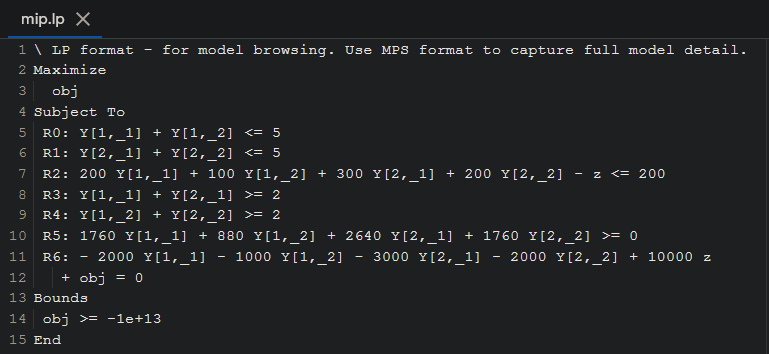

# **Desagregando el modelo (en funcion de los clientes)**

**Conjuntos:**

$c \in C_k$: Conjunto de clientes que pertenecen al segmento k.

$k \in K$ : Segmentos de clientes.

$j \in J_k$ : Conjunto de productos que se ofrecen al segmento k.

**Parametros:**

$\pi_{ckj}$ : Rentabilidad esperada de ofrecer el producto j al cliente c del segmento k.

**Variables:**

$X_{c j k} \in (0, 1)$: Si al cliente c del segmento k, le ofrezco el producto j

**Funcion Objetivo:**

\begin{equation}
Max \sum_{k} \sum_{c \in C_k} \sum_{j \in J_k} \pi_{cjk} X_{cjk}
\end{equation}

**Restricciones:**

1) La cantidad de asignaciones de producto debe calzar con las cantidades agregadas de productos del modelo anterior.

\begin{equation}
\sum_{c \in C_k}X_{ckj} \leq Y_{k j} \quad \forall j \in J_k, k \in K
\end{equation}

2) No puedo afrecer el mismo producto a dos clientes distintos.

\begin{equation}
\sum_{j \in J_k} X_{cjk} \leq 1
\quad \forall c \in C_k, k \in K
\end{equation}

3) Ajustar los costos de las campañas al nuevo presupusto disponible.

\begin{equation}
\sum_{k} \sum_{c \in C_k} \sum_{j \in J_k} v_{kcj} X_{kcj} \leq B'
\end{equation}



In [ ]:
# Nuevos conjuntos

## Clientes por segmento
C_k = {1:[1, 2, 3, 4, 5], 
       2:[6, 7, 8, 9, 10]}

## Productos por cliente (Para el ejercicio no hicieron que dependiera)
J_k = {1:[1, 2], 
       2:[1, 2]}

## Conjunto de segmentos
K = [1, 2]


In [ ]:
# Nuevo parametros

## Rentibilidades de los clientes individuales
pi_kcj = {
    (1, 1, 1): 2050,
    (1, 1, 2): 1050,
    (1, 2, 1): 1950,
    (1, 2, 2): 950,
    (1, 3, 1): 2000,
    (1, 3, 2): 1000,
    (1, 4, 1): 2100,
    (1, 4, 2): 1100,
    (1, 5, 1): 1900,
    (1, 5, 2): 900,
    (2, 6, 1): 3000,
    (2, 6, 2): 2000,
    (2, 7, 1): 2900,
    (2, 7, 2): 1900,
    (2, 8, 1): 3050,
    (2, 8, 2): 2050,
    (2, 9, 1): 3100,
    (2, 9, 2): 3100,
    (2, 10, 1): 2950,
    (2, 10, 2): 2950}

# Costo de aplicar la campaña a los clientes de manera individual
v_kcj = {
    (1, 1, 1): 205,
    (1, 1, 2): 105,
    (1, 2, 1): 195,
    (1, 2, 2): 95,
    (1, 3, 1): 200,
    (1, 3, 2): 100,
    (1, 4, 1): 210,
    (1, 4, 2): 110,
    (1, 5, 1): 190,
    (1, 5, 2): 90,
    (2, 6, 1): 300,
    (2, 6, 2): 200,
    (2, 7, 1): 290,
    (2, 7, 2): 190,
    (2, 8, 1): 305,
    (2, 8, 2): 205,
    (2, 9, 1): 310,
    (2, 9, 2): 310,
    (2, 10, 1): 295,
    (2, 10, 2): 295}

# Nuevo presupuesto (son los 200 iniciales + 400 recomendados del modelo anterior)
B_ = 600


In [ ]:
# Nuevo modelo
m2 = Model()

# Nueva variable
X = {}
for k in K:
  for c in C_k[k]:
    for j in J_k[1]: # Esto lo deje asi, para no agregar variables que no se utilizan en este ejercicio particular
      X[k, c, j] = m2.addVar(vtype=GRB.BINARY, name='X[{}, {}, {}]'.format(k, j, c))
      #print('x[{}, {}, {}]'.format(k, c, j))

obj = m2.addVar(lb=-100000000, name='obj')

In [ ]:
# Nuevas restricciones

## 1) La cantidad de asignaciones debe corresponder con las obtenidas del mdoelo anterior
for k in K:
  for j in J_k[1]:
    m2.addConstr(quicksum(X[k, c, j] for c in C_k[k]) == Y[k, j].x)

In [ ]:
## 2) No puedo afrecer el mismo producto a mas de un cliente del mismo segmento
for k in K:
  for c in C_k[k]:
    m2.addConstr(quicksum(X[k, c, j] for j in J_k[1]) <= 1)
    

In [ ]:
## 3) restriccion de presupuesto
m2.addConstr(quicksum(v_kcj[k, c, j]*X[k, c, j] for k in K for j in J_k[1] for c in C_k[k]) <= B_)

<gurobi.Constr *Awaiting Model Update*>

In [ ]:
## 4) Funcion objetivo
m2.addConstr(obj == quicksum(pi_kcj[k, c, j]*X[k, c, j] for k in K for j in J_k[1] for c in C_k[k]))


<gurobi.Constr *Awaiting Model Update*>

In [ ]:
# Colocar el objetivo
m2.setObjective(obj, GRB.MAXIMIZE)
m2.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 16 rows, 21 columns and 81 nonzeros
Model fingerprint: 0x2076aa51
Variable types: 1 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+08]
  RHS range        [1e+00, 6e+02]
Presolve removed 8 rows and 11 columns
Presolve time: 0.00s
Presolved: 8 rows, 10 columns, 28 nonzeros
Variable types: 0 continuous, 10 integer (10 binary)
Found heuristic solution: objective 6000.0000000

Root relaxation: cutoff, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      6000.00000 6000.00000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.05 seconds
Thread count was 2 (of 2

In [ ]:
# Rescatar los valores de la salida
for k in K:
  for j in J_k[1]:
    for c in C_k[k]:
      if X[k, c, j].x > 0:
        print('X[k={}, c={}, j={}]: {}     Ganancia: {}      costo: {}'.format(k, c, j, X[k, c, j].x, pi_kcj[k, c, j], v_kcj[k, c, j]))

print('obj: ', obj.x)

X[k=1, c=1, j=1]: 1.0     Ganancia: 2050      costo: 205
X[k=1, c=2, j=1]: 1.0     Ganancia: 1950      costo: 195
X[k=1, c=4, j=2]: 1.0     Ganancia: 1100      costo: 110
X[k=1, c=5, j=2]: 1.0     Ganancia: 900      costo: 90
obj:  6000.0
